In [4]:
import pandas as pd
import numpy as np
#import pickle
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('C:/Users/ruiwa/Documents/课件/Machine learning/train.csv')

In [6]:
df.columns

Index(['label', 'id', 'visitTime', 'purchaseTime', 'hour', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'N1', 'C9', 'N2', 'N3', 'N4', 'N5', 'N6',
       'N7', 'N8', 'N9', 'N10', 'C10', 'C11', 'C12'],
      dtype='object')

In [7]:
df['C1'].value_counts()

2569487005    8430
2108523568       7
2084406919       6
3438432991       5
256353298        5
              ... 
1427705163       1
4180196685       1
596547023        1
3559230936       1
77004800         1
Name: C1, Length: 22595, dtype: int64

In [8]:
df['C3'].value_counts()

1928325921    1232
3475347077    1212
2780744710    1179
1711803242     936
1822656032     536
              ... 
3540895230       1
2756181513       1
3550862535       1
1199484467       1
1533319149       1
Name: C3, Length: 2863, dtype: int64

In [9]:
df['C10'].value_counts()

3469607743    1425
3458698981      82
3183725626      73
1133005353      71
3662869197      68
              ... 
843115400        1
762569609        1
4142922634       1
830608273        1
487200771        1
Name: C10, Length: 28653, dtype: int64

In [10]:
label = df['label'].values

In [11]:
data = df.drop(columns=['label','id','visitTime','purchaseTime','C1','C3','C10']).values

In [12]:
X = data.copy()
y = np.array(label.copy())
y[:5]

array([-1, -1, -1, -1, -1])

# In the following, we try to build a baseline model (which is not the optimal solution)

# Split data into training and testing

In [13]:
y = (y > 0)*1
nb_class = len(set(y))
print(nb_class)
id_Train = np.array([None]*nb_class)
id_Test = np.array([None]*nb_class)
for i in range(nb_class):
    id_i = np.where(y==i)[0]
    id_i_train, id_i_test = train_test_split(id_i, test_size=0.2)
    id_Train[i] = id_i_train
    id_Test[i] = id_i_test

id_Train = np.concatenate(id_Train)
id_Test = np.concatenate(id_Test)

X_train = X[id_Train]
Y_train = y[id_Train]
X_test = X[id_Test]
Y_test = y[id_Test]

2


In [14]:
set(y)

{0, 1}

In [15]:
X_train[0]

array([         8,  403381353,  652481754, 2967512603, 1719752289,
       2303407174,  157533148,          0, 3595738046,          0,
                0,          0,          0,          0,          0,
                0,          0,          0, 3617851689, 4220791646])

Re-sampling

In [16]:
id_toTrain = np.array([np.where(Y_train==i)[0] for i in range(nb_class)])

size_max = [len(id_toTrain[i]) for i in range(nb_class)]
print("before resampling")
print(size_max)

blc = 150
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+1))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i])+1))

print("after resampling")
print(size_max)
for i in range(nb_class):
    if len(id_toTrain[i]) > size_max[i]:
        id_toTrain[i], tmp = train_test_split(id_toTrain[i], test_size=1-size_max[i]/len(id_toTrain[i]))
    else:
        id_toTrain[i] = np.concatenate((id_toTrain[i], id_toTrain[i][np.random.randint(len(id_toTrain[i]), size=int(size_max[i]-len(id_toTrain[i])))]))
id_toTrain = np.concatenate(id_toTrain)
X_toTrain = X_train[id_toTrain]
Y_toTrain = Y_train[id_toTrain]

before resampling
[25096, 45]
after resampling
[483, 98]


# If you want to work with xgboost, you should use xgboost from sklearn to predict the probability (here is another xgboost package)

In [60]:
#xgboost package error, so used XGBRegressor

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

#dTrain = xgb.DMatrix(X_toTrain,label=Y_toTrain)
#dTest = xgb.DMatrix(X_test)
#dtrain = xgb.DMatrix(X_train)
#dPred = xgb.DMatrix(X)

#clf = xgb.train({'max_depth': 60, 'num_class': nb_class, 'gamma': 10,'colsample_bytree': 0.4, 'subsample': 0.7, 'num_round': 10000, 'min_child_weight': 4, 'n_estimators': 2000, 'n_jobs': -1, 'learning_rate': 0.01, 'reg_alpha': 0.5},dTrain, num_boost_round = 200)


In [26]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [28]:
model2 = xgb.XGBRegressor()
model2.fit(X_toTrain, Y_toTrain)
y_pred = model2.predict(X_test)

-7.119232229555501

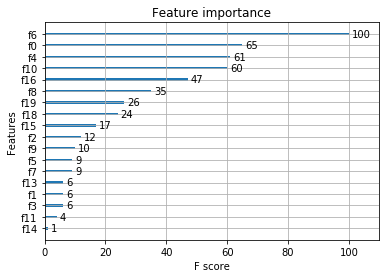

In [29]:
from xgboost import plot_importance
plot_importance(model2)
plt.show() 

In [86]:
ratio = float(np.sum(label == -1)) / np.sum(label == 1)
from sklearn.model_selection import RandomizedSearchCV
gbm_param_grid = {
    'n_estimators': range(100, 300),
    'max_depth': range(20, 40),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]    
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10, scale_pos_weight = ratio)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "f1", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(X_train, Y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [83]:
y_pred = xgb_random.predict(X_test)


In [84]:
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
print(roc_auc_score(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6275
           1       0.36      0.83      0.50        12

    accuracy                           1.00      6287
   macro avg       0.68      0.92      0.75      6287
weighted avg       1.00      1.00      1.00      6287

[[6257   18]
 [   2   10]]
0.9152324037184595


In [31]:
test = pd.read_csv("/Users/liu/Desktop/ML individual work/test1.csv")
test = test.drop(columns=['label','id','visitTime','purchaseTime','C1','C3','C10']).values


In [32]:
xgb_pred = xgb_random.predict(test)

In [51]:
probas = xgb_random.predict_proba(test)
probability = pd.DataFrame(data=probas)

In [49]:
result = pd.concat([pd.DataFrame(test), pd.DataFrame(xgb_pred)], axis = 'columns')
result = pd.concat([pd.DataFrame(result),probability],axis='columns')

In [50]:
result.to_csv('C:/Users/ruiwa/Documents/课件/Machine learning/train.csv', header = True, index = False)

In [18]:
clf.save_model("first_model.m")

In [19]:
clf.load_model("first_model.m")

In [ ]:
#ypred = clf.predict

In [1]:
#Y_pred = clf.predict(dTest)
#print(classification_report(Y_test,Y_pred))

In [ ]:
#Y_pred = clf.predict(dtrain)
#print(classification_report(Y_train,Y_pred))
#Y_to_pred = clf.predict(dPred)
#print([len(np.where(Y_to_pred==i)[0]) for i in range(nb_class)])

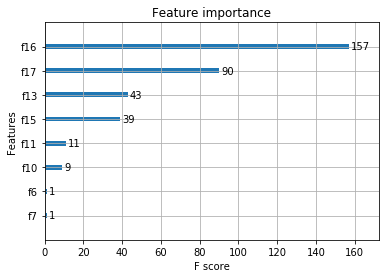

In [27]:
xgb.plot_importance(clf, importance_type = 'weight', max_num_features=15)
plt.show()

As we may seen, the baseline model is not so good. You should do some improvements. Here is one of the final results that we've obtained:

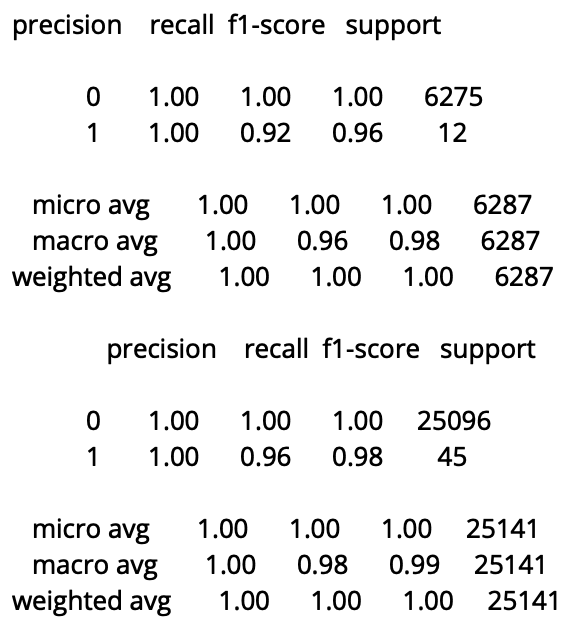